# Intervening on a model

Here's a common pattern. A researcher trains a model to perform some task. Then, they ask something like: what if I did that again, but interfered with a specific part of the state of the model? 

A powerful feature of Feedbax is the ability to rapidly modify models and tasks with *interventions*.

Let's see how this works. We'll start by training a model just like we did in the first [example](/feedbax/examples/0_train_simple).

In [2]:
import jax.random as jr

from feedbax.xabdeef import point_mass_nn_simple_reaches

seed = 1234
key_init, key_train, key_eval = jr.split(jr.PRNGKey(seed), 3)

context = point_mass_nn_simple_reaches(key=key_init)
task = context.task  # Shorthand, for later

model, train_history = context.train(
    n_batches=1000,
    batch_size=250,
    learning_rate=1e-2,
    log_step=500,
    key=key_train,
)

Training step compiled in 3.90 seconds.
Validation step compiled in 1.01 seconds.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.39e+01
	validation loss: 5.36e+00

Training iteration: 500
	training loss: 4.01e-03
	validation loss: 7.44e-04

Training iteration: 999
	training loss: 2.68e-03
	validation loss: 5.71e-04

Completed training run on a total of 250,000 trials.


And evaluate the trained model on the task's validation set of center-out reaches.

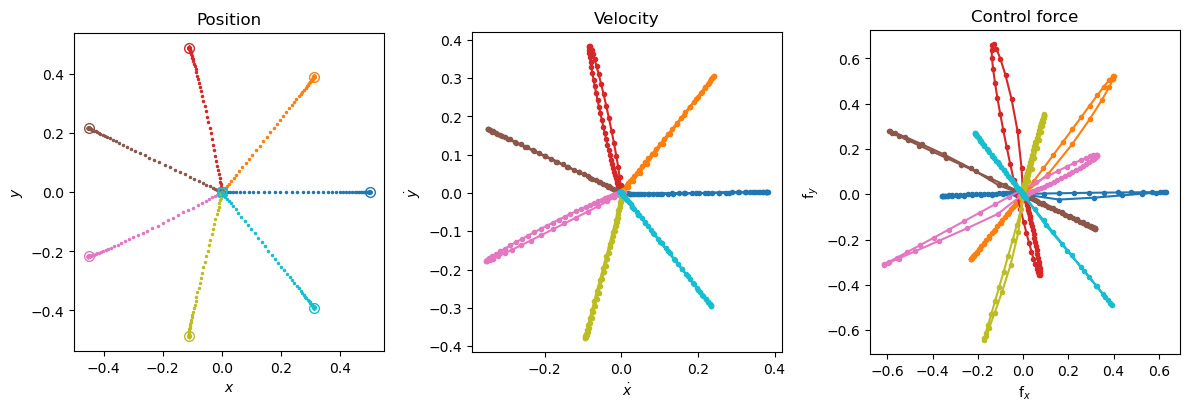

In [3]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model, key=key_eval)

_ = plot_reach_trajectories(states, trial_specs=task.validation_trials)

## Adding a force field

Those reaches look pretty straight. Maybe that's not surprising, since 1) the point mass isn't being disturbed by any forces other than those generated by the network, and 2) the [loss function](/feedbax/examples/0_train_simple#interpreting-the-training-history) favours moving as directly as possible to the goal.

What happens if we add a clockwise curl force field? That means that the faster the point mass is moving in some direction, the harder the field will push it to the right, relative to that direction.

In [4]:
from feedbax.intervene import add_intervenor, CurlField

model_curl = add_intervenor(
    model,
    CurlField.with_params(amplitude=-0.5),  # negative -> clockwise
    where=lambda m: m.step.mechanics,
)

The function [`add_intervenor`][feedbax.intervene.add_intervenor] takes a model and an *intervenor*, and returns a model that includes the intervenor.

!!! Note ""    
    We have to specify that the curl field should specifically be added to `model.step.mechanics`, since that's the relevant level of the model for this kind of intervention. 

What's the effect of the curl field on reaches?

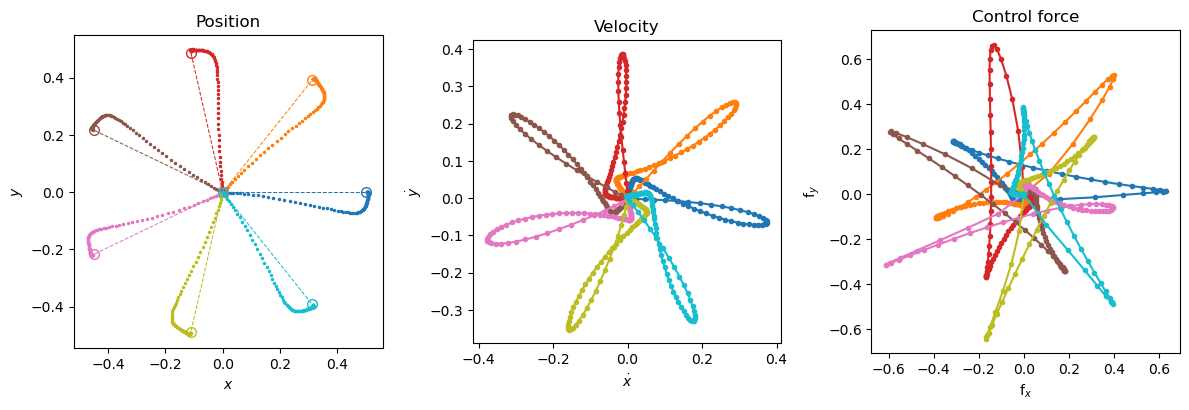

In [5]:
_ = plot_reach_trajectories(
    task.eval(model_curl, key=key_eval),
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)

## Scheduling a force field

By adding an intervention using `add_intervenor`, we obtained an model that always applied a curl force field at all times, and on every trial. 

Often, we want an intervention to only appear on some trials, or for the parameters of the intervention to change between or within trials. In that case, we have to modify `task` as well, since it is in control of any parameters which systematically vary between trials.  

For this, we use [`schedule_intervenor`][feedbax.intervene.schedule_intervenor], which both adds the intervention to the model, and modifies the task to generate the parameters that will be used to control the intervention on each trial.

In [6]:
from feedbax.intervene import schedule_intervenor

curl_std = 0.5

task_random_curl, model_random_curl = schedule_intervenor(
    task, model,
    CurlField.with_params(
        amplitude=lambda trial_spec, key: curl_std * jr.normal(key, shape=(1,)),
    ),
    where=lambda model: model.step.mechanics,
)

When passing an intervenor to `schedule_intervenor`, we can control how some or all of its parameters are generated *for each trial* by passing functions instead of constants.

!!! Note ""    
    The functions must accept two arguments. 
    
    - The first is a `TaskTrialSpec` object, which contains the other parameters that define the trial for which the parameters are being generated—for example, the location of a reach target. This allows us to control our interventions based on the characteristics of the current task. 
    - The second is a random key, which the function can use if it needs to generate trial-random data. 

In this case, we've passed a `lambda` that samples, for each trial, a zero-mean normally-distributed amplitude for the curl field. So the curl field should vary in size and direction, between trials.

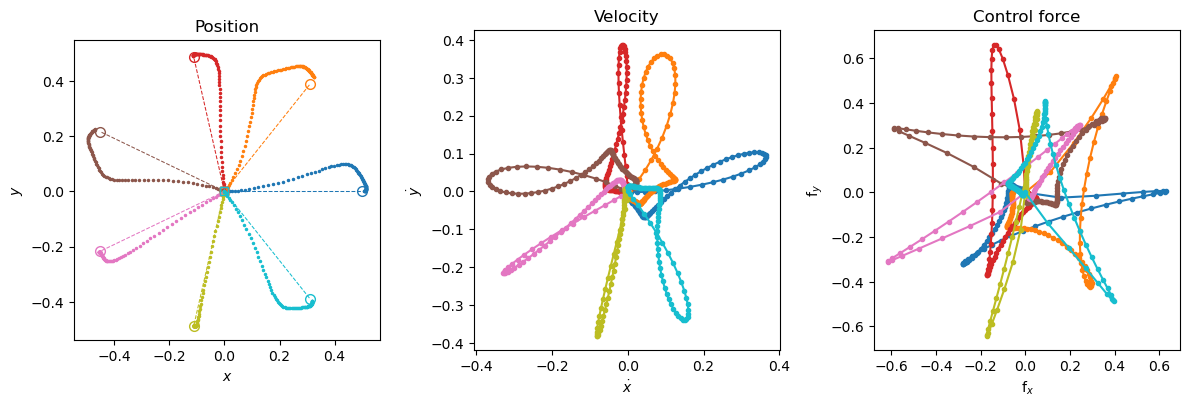

In [8]:
_ = plot_reach_trajectories(
    task_random_curl.eval(model_random_curl, key=key_eval),
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)

By default, `schedule_intervenor` will modify both the training trials and the validation trials of a task. In the above example, this didn't matter because we only wanted to evaluate the effect of the curl field on the center-out validation trials. 

However, we can easily pass different parameter specifications for training and validation trials. 

In [ ]:
from feedbax.intervene import CurlFieldParams

curl_std = 0.5

task_random_curl, model_random_curl = schedule_intervenor(
    task, model,
    CurlField,
    intervention_spec=CurlFieldParams(
        amplitude=lambda trial_spec, key: curl_std * jr.normal(key, shape=(1,)),
        # active=True,  # This is the default, so we don't need to specify it
    ),
    intervention_spec_validation=CurlFieldParams(
        active=False   # No random curls during validation!
    ),
    where=lambda model: model.step.mechanics,
)

## Adding noise to state variables

It only makes sense to add a `CurlField` perturbation to a `Mechanics` module. Some other kinds of perturbations are more general than that, and could be added pretty much anywhhere.

As its name suggests, `AddNoise` is for adding noise to a part of the model state. It could make sense to add noise to *any* part of the model state.  

In [ ]:
from feedbax.intervene import AddNoise

noise_where = lambda network_state: network_state.hidden

model_noise = add_intervenor(
    model,
    AddNoise.with_params(
        in_where=noise_where,
        out_where=noise_where,
        noise_func=jr.normal,
        scale=0.05,
    ),
    where=lambda model: model.step.network,
)